In [1]:
!git clone https://github.com/openai/CLIP.git
# CLIP (Contrastive Language-Image Pre-training)
# Learning Transferable Visual Models from Natural Language Supervision (Paper)

!git clone https://github.com/CompVis/taming-transformers
# Taming transformers for High-resolution Image Synthesis


Cloning into 'CLIP'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 247 (delta 0), reused 1 (delta 0), pack-reused 243
Receiving objects: 100% (247/247), 8.93 MiB | 22.46 MiB/s, done.
Resolving deltas: 100% (124/124), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340
Receiving objects: 100% (1342/1342), 409.77 MiB | 42.50 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [2]:
# Install extra libraries
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops
!pip install taming-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 12.4 MB/s eta 0:00:00
Found existing installation: torchtext 0.15.2
Uninstalling torchtext-0.15.2:
  Successfully uninstalled torchtext-0.15.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 922.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.2 MB/s eta 0:00:00


In [3]:
# Importing libraries
import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import PIL
import matplotlib.pyplot as plt
import yaml
from omegaconf import OmegaConf
from CLIP import clip

In [32]:

# Helper functions

def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1, 2, 0))
  plt.figure(figsize=(10, 7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()


def norm_data(data):
  return (data.clip(-1, 1)+1)/2 # Move to range between 0 and 1

# Parameters
learning_rate = 0.5
batch_size = 1
wd = 0.1
noise_factor = 0.1

total_iter = 3000
im_shape = [225, 400, 3] # height, width, channel
size1, size2, channels = im_shape

In [5]:
## CLIP MODEL ##
clipmodel, _ = clip.load('ViT-B/32', jit=False) # Visual Transformer
clipmodel.eval()
print(clip.available_models())

print("Clip model visual input resolution: ", clipmodel.visual.input_resolution)

device = torch.device("cuda:0")
torch.cuda.empty_cache()


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 141MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution:  224


In [6]:
## Taming Transformer Instantiation ##
%cd taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
  !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
  !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'


/content/taming-transformers
--2023-10-11 15:44:54--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/1c8502b8-de32-4ad1-8e0b-dd963fa2bed4/last.ckpt [following]
--2023-10-11 15:44:54--  https://heibox.uni-heidelberg.de/seafhttp/files/1c8502b8-de32-4ad1-8e0b-dd963fa2bed4/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  14.9MB/s    in 63s     

2023-10-11 15:45:58 (14.8 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092370/980

In [7]:
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
  config_data = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config_data)))
  return config_data


def load_vqgan(config, chk_path=None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location='cpu')['state_dict']
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
  return model.eval()


def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x


taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)



model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


100%|██████████| 528M/528M [00:02<00:00, 246MB/s]


8.19kB [00:00, 226kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [8]:
### Declare the latent space to optimize

class Parameters(torch.nn.Module):
  def __init__(self):
    super(Parameters, self).__init__()
    self.data = 0.5 * torch.randn(batch_size, 256, size1//16, size2//16).cuda() # tensor of random values 1 x 256 x 14 x 25
    self.data = torch.nn.Parameter(torch.sin(self.data)) # To embed mathematical information about positioning to the data

  def forward(self):
    return self.data


def init_params():
  params = Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data], 'lr': learning_rate}], weight_decay=wd)
  return params, optimizer

torch.Size([1, 256, 14, 25])
img dimensions:  torch.Size([1, 3, 224, 400])


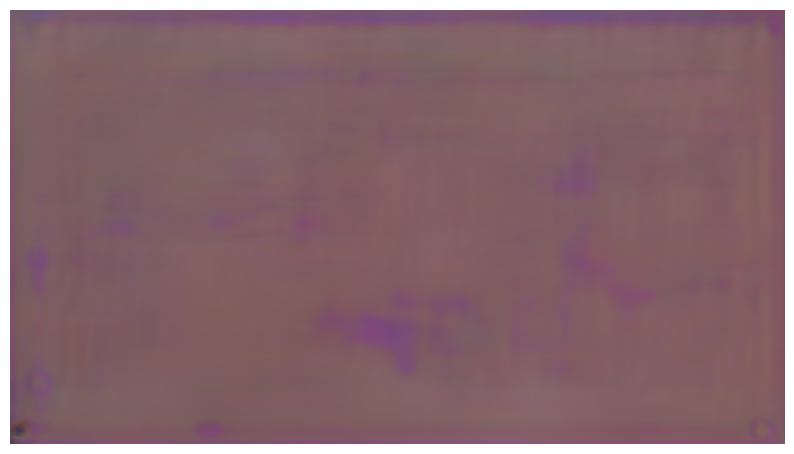

In [15]:
## Encoding prompts and some other stuff

normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.2757771))

def encodeText(text):
  t = clip.tokenize(text).cuda()
  t = clipmodel.encode_text(t).detach().clone()
  return t


def createEncodings(include, exclude, extras):
  include_enc = []
  for text in include:
    include_enc.append(encodeText(text))
  exclude_enc = encodeText(exclude) if exclude != '' else 0
  extras_enc = encodeText(extras) if extras != '' else 0

  return  include_enc, exclude_enc, extras_enc


augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)
).cuda()

Params, optimizer = init_params()

with torch.no_grad():
  print(Params().shape)
  img = norm_data(generator(Params()).cpu()) # 1 x 3 x 224 x 400 [225 x 400 target]
  print("img dimensions: ", img.shape)
  show_from_tensor(img[0])



In [17]:
# Create Crops of the image

def create_crops(img, num_crops=30):
  p  = size1//2
  img = torch.nn.functional.pad(img, (p, p, p, p), mode='constant', value=0) # 1 x 3 x 448 x 624 (adding 112 on all sides to 224 x 400)
  img = augTransform(img) # RandomHorizontalFlip and RandomAffine

  crop_set = []
  for ch in range(num_crops):
    gap1 = int(torch.normal(1.0, .5, ()).clip(.2, 1.5) * size1)
    gap2 = int(torch.normal(1.0, .5, ()).clip(.2, 1.5) * size1)
    offsetx = torch.randint(0, int(size1*2 - gap1), ())
    offsety = torch.randint(0, int(size1*2 - gap1), ())

    crop = img[:, : , offsetx:offsetx+gap2, offsety:offsety+gap2]

    crop = torch.nn.functional.interpolate(crop, (224, 224), mode='bilinear', align_corners=True)
    crop_set.append(crop)

  img_crops = torch.cat(crop_set, 0) # 30 x 3 x 224 x 224

  img_crops = img_crops + noise_factor*torch.randn_like(img_crops, requires_grad=False)

  return img_crops


In [19]:
# Show current state of Generation

def showme(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params())

    if show_crop:
      print("Augmented cropped example")
      aug_gen = generated.float() # 1 x 3 x 224 x 400
      aug_gen = create_crops(aug_gen, num_crops=1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print("Genration")
    latest_gen = norm_data(generated.cpu()) # 1 x 3 x 224 x 400
    show_from_tensor(latest_gen[0])

  return latest_gen[0]

In [12]:
# Optimization process
def optimize_result(Params, prompt):
  alpha = 1 # Importance of the include encodings
  beta = .5 # The importance of the exclude encodings

  # Image Encoding
  out = generator(Params())
  out = norm_data(out)
  out = create_crops(out)
  out = normalize(out) # 30 x 3 x 224 x 224
  image_enc = clipmodel.encode_image(out) # 30 x 512

  # Text Encoding
  final_enc = w1*prompt + w1*extras_enc # Propmpr and extras_enc :  1 x 512
  final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
  final_text_exclude_enc = exclude_enc

  # Calculate the loss
  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1) # 30
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) # 30

  final_loss = -alpha*main_loss + beta * penalize_loss
  return final_loss


def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [13]:
# Training Loop

def training_loop(Params, optimizer, show_crop=False):
  res_img = []
  res_z = []

  for prompt in include_enc:
    iteration = 0
    Params, optimizer = init_params() # 1 x 256 x 14 x 25 (225/6, 400/16)

    for iteration in range(total_iter):
      loss = optimize(Params, optimizer, prompt)

      if iteration > 0 and iteration % (total_iter - 1) == 0:
        new_img = showme(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params()) # 1 x 256 x 14 x 25
        print("loss: ", loss.item(), "\niteration: ", iteration)
      iteration += 1
    torch.cuda.empty_cache()
  return res_img, res_z

Augmented cropped example


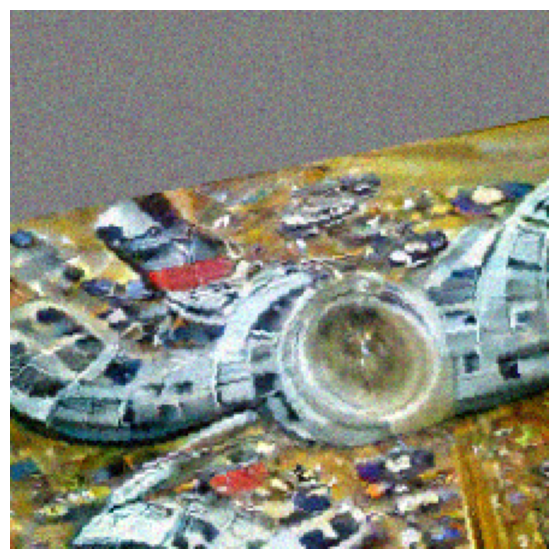

Genration


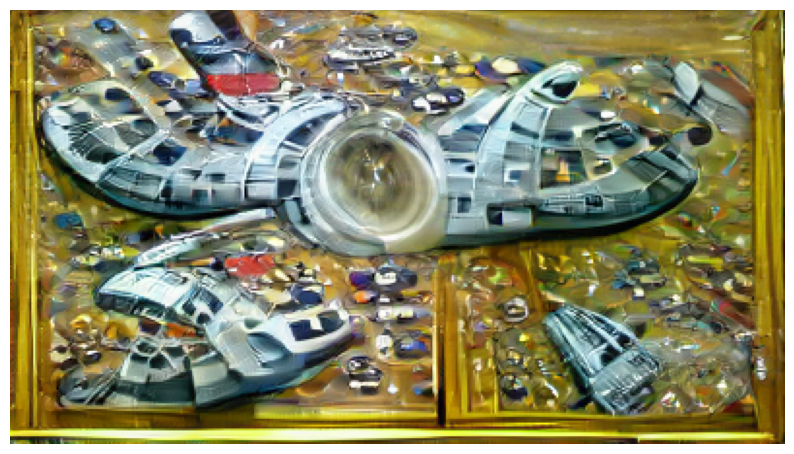

loss:  -0.19970703125 
iteration: 0 2999


In [33]:
torch.cuda.empty_cache()
include =  ['The millenium Falcon']
exclude = 'watermarks, cropped, confusing, incoherent, blurry'
extras = 'Oil painting'
w1 = 1
w2 = 1

include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z = training_loop(Params, optimizer, show_crop=True)